<a href="https://colab.research.google.com/github/DavidMCV97/debt_classification/blob/debt_analysis_2/BBVA_debt_classification_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBVA debt classification
This is the second model we'll use for the debt classification of BBVA. Somo of the steps are similar to the first model *BBVA discounts analysis* \\
First we import some libraries and mount the google drive files.

In [ ]:
from google.colab import drive # to mount drive files
import pandas as pd # for dataframes
import numpy as np # for numerical processes
import matplotlib.pyplot as plt # for graphs

In [ ]:
drive.mount('/content/drive') # we make available the drive files

Mounted at /content/drive


Second we import the discounts base, correct the data types and clean it.

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_activities(no_pilot).csv')
base.inicio_programa = pd.to_datetime(base.inicio_programa,format='%Y-%m-%d',errors='coerce') # errors in cast will be NaT
base.ultimo_pago = pd.to_datetime(base.ultimo_pago,format='%Y-%m-%d',errors='coerce')
base.executed_date = pd.to_datetime(base.executed_date,format='%Y-%m-%d',errors='coerce')
base[['bank_reference','debt_id','banco','num_tarjeta']] = base[['bank_reference','debt_id','banco','num_tarjeta']].astype(str) #simultaneous cast
base.drop(base[base.isnull().any(axis=1)].index,inplace=True) #drop rows with null or NaT values
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bank_reference   21854 non-null  object        
 1   debt_id          21854 non-null  object        
 2   banco            21854 non-null  object        
 3   num_tarjeta      21854 non-null  object        
 4   deuda_resuelve   21854 non-null  float64       
 5   inicio_programa  21854 non-null  datetime64[ns]
 6   ultimo_pago      21854 non-null  datetime64[ns]
 7   executed_date    21854 non-null  datetime64[ns]
 8   pago_a_bancos    21854 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 1.5+ MB


Third, we add the bins to the base and merge them with the bin intrest rate. \\
We'll drop the wrong bank type so please specify the bank type imput and default interest rate

In [ ]:
bank_input = 'card' # imput card or loan
default_interest_rate = 0.04

In [ ]:
cards = base.num_tarjeta.str.replace('\D','',regex=True)
cards_len = cards.str.len()
base['bank_type'] = np.where((cards_len >= 15)&(cards_len <= 17), 'card','loan')
base['Bin'] = cards.str[:6]
base = base[base.bank_type == bank_input]

In [ ]:
bins = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_bins.csv')
bins = pd.DataFrame(bins)
bins['Bin'] = bins['Bin'].astype(str)
bins = bins.drop_duplicates('Bin')

In [ ]:
base = pd.merge(base, bins, on = 'Bin', how = 'left')

In [ ]:
base.tasa = base.tasa.fillna(default_interest_rate)
base[['debt_id','Bin','tasa']].sample(10)

,debt_id,Bin,tasa
7718,1304227,477214,0.0375
1016,784181,477213,0.0375
3995,1222973,477213,0.0375
785,652052,554629,0.0400
3655,1212528,477213,0.0375
6652,1281706,477213,0.0375
7350,1296306,477214,0.0375
8594,1330242,477214,0.0375
5750,1261153,477291,0.0375
3809,1217689,477291,0.0375


Fourth, we calculate the balance and discount. Please specify the max period of interest grow.

In [ ]:
max_period = 18 #max period of interest grow
tolerance_rate = 3 # max number of times a payment can be bigger than the original debt,
                   # bigger values will be considered mistakes
max_discount = 0.99 #discounts bigger than this will be considered mistakes

In [ ]:
base['deliq_beginning_prog'] = (base.inicio_programa.dt.year - base.ultimo_pago.dt.year)*12 + base.inicio_programa.dt.month - base.ultimo_pago.dt.month
base.deliq_beginning_prog = np.where(base.deliq_beginning_prog < 0, 0, base.deliq_beginning_prog)
base['deliq_act'] = (base.executed_date.dt.year - base.ultimo_pago.dt.year)*12 + base.executed_date.dt.month - base.ultimo_pago.dt.month
base.drop(base[base.deliq_act <0].index,inplace=True) # we drop negative periods as there must be a payment after the discount
base['aux_balance'] = np.where(base.deliq_beginning_prog > max_period, 0,
                      np.where(base.deliq_act > max_period, max_period - base.deliq_beginning_prog,
                               base.deliq_act - base.deliq_beginning_prog))
base['balance'] = base.deuda_resuelve*(1 + base.tasa)**(base.aux_balance)
base['real_discount'] = 1-base.pago_a_bancos/base.balance
base.drop(base[base.deuda_resuelve*tolerance_rate < base.pago_a_bancos].index, inplace = True)
base.drop(base[base.real_discount > max_discount].index,inplace=True)
base[['debt_id','deuda_resuelve','pago_a_bancos','tasa','aux_balance','balance','real_discount']].sample(10)

,debt_id,deuda_resuelve,pago_a_bancos,tasa,aux_balance,balance,real_discount
7119,1289691,27820.56,3238.0,0.0375,5,33443.089768,0.903179
2073,1122886,37154.14,4580.0,0.0375,10,53689.364951,0.914694
3848,1217119,13470.90,4500.0,0.0375,5,16193.366271,0.722108
6845,1285094,11168.11,4700.0,0.0375,3,12472.226782,0.623163
1987,1113820,47917.00,6287.0,0.0375,11,71838.751997,0.912485
4873,1247191,34664.12,15042.0,0.0375,1,35964.024500,0.581749
8341,1318015,11385.15,2177.0,0.0375,4,13191.408773,0.834968
9603,1373360,28889.19,20252.0,0.0375,2,31096.504673,0.348737
3397,1201853,56584.58,8436.0,0.0375,7,73217.489629,0.884782
3454,1204700,76946.19,10764.0,0.0375,7,99564.348950,0.891889


Let's see how the discounts look!

(0.0, 22.0)

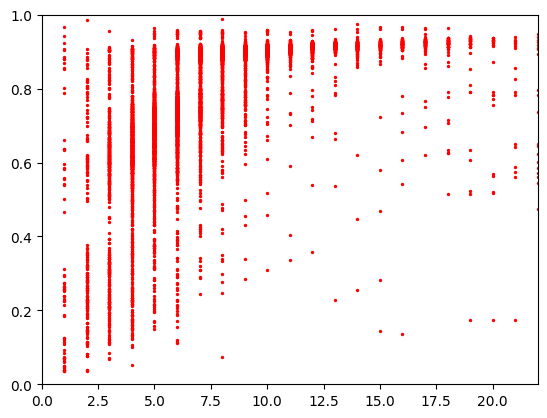

In [ ]:
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,22) # x axis size

I want to define 3 discount curves with
1.   Beggining in 0
2.   Logarithmic shape
3.   equaly separated
The criterion i will use to define the curves are percentils. To make them equally separated theoretically, i will take percentils 25, 50 and 75. Also, i will just take until the 20 month, as the discount falls from there.



In [ ]:
size = 20
c1, c2, c3 = np.zeros(size), np.zeros(size), np.zeros(size)
for month in range(1,size):
  c1[month] = np.percentile(base[base.deliq_act == month].real_discount,25)
  c2[month] = np.percentile(base[base.deliq_act == month].real_discount,50)
  c3[month] = np.percentile(base[base.deliq_act == month].real_discount,75)

In [ ]:
c2

array([0.        , 0.25898441, 0.306873  , 0.59929549, 0.64234184,
       0.68611493, 0.7392842 , 0.87150409, 0.89414324, 0.90029353,
       0.90443422, 0.90858041, 0.91309661, 0.91453303, 0.91471797,
       0.91680937, 0.92043305, 0.92372742, 0.92228844, 0.92149116])

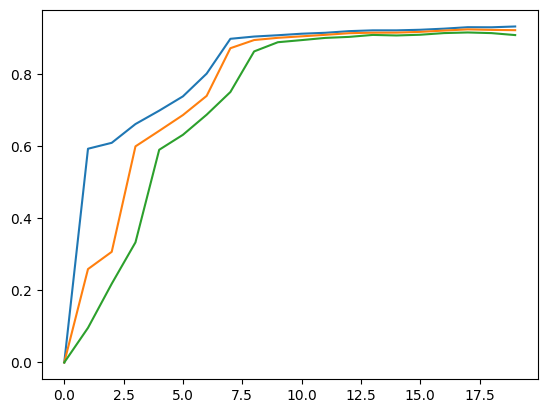

In [ ]:
plt.plot(c3)
plt.plot(c2)
plt.plot(c1)

Now I will adjust a logarithmic function to the curves. Lets set initial conditions first

In [ ]:
curve = c2
a0 = [0.18,10] # initial parameters
a1 = a0 + np.random.rand(2) # second initial parameters
iterations =100 # num of iterations
step = 0.05 # step size for gradent descent method
max_discount = 0.85 # maximum discount

i will use the gradent descent method as i dont really need nothing more complex

In [ ]:
def grad_desc(f,x0,x1,iterations,step):
  # this is the gradent descent method for R**2 -> R functions that uses
  # numerical aproximations of the derivate of the function.
  save_x = [x0,x1] # we save the history of parameters and function evaluations
  save_f = [f(x0),f(x1)] # we save them as a python list bc is changable and ordered
  xii = x0
  xjj = x1 # j = i + 1
  it = 0
  #breakpoint()
  while it < iterations and any(xii != xjj):
    xji = np.array([xjj[0],xii[1]])
    xij = np.array([xii[0],xjj[1]])
    df_dx = (f(xji)-f(xii)) / (xjj[0]-xii[0])
    df_dy = (f(xij)-f(xii)) / (xjj[1]-xii[1])
    mov = np.array([df_dx,df_dy]) * (-step)
    xii = xjj
    xjj = xjj + mov
    save_x.append(xjj)
    save_f.append(f(xjj))
    it = it + 1
  return save_x,save_f # we return the history of values, being the last one the best one

In [ ]:
from sklearn.metrics import mean_squared_error

results = pd.DataFrame(columns=['add','MSE','a'])
for add in range(5):
  def f(a,x):
    if (x-add)*a[1] <= 0:
      res = 0
    else:
      res = min(max_discount,max(0,a[0]*np.log((x-add)*a[1])))
    return res
  def MSE(a):
    F = []
    for x in range(len(curve)):
        F.append(f(a,x))
    return mean_squared_error(F,curve)
  history_a, history_f = grad_desc(MSE,a0,a1,iterations,step)
  results.loc[add,:] = [add,history_f[-1],history_a[-1]]

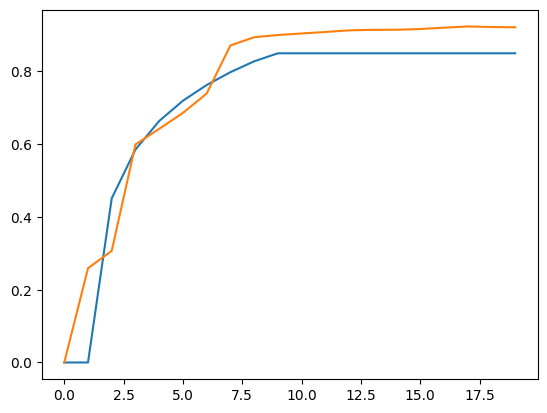

In [ ]:
opt = results.MSE.astype('float').idxmin()
def f(a,x):
  if (x-opt)*a[1] <= 0:
    res = 0
  else:
    res = min(max_discount,max(0,a[0]*np.log((x-opt)*a[1])))
  return res
a_star = results.loc[opt,'a']
curve_adjusted = [f(a_star,x) for x in range(size)]
plt.plot(curve_adjusted)
plt.plot(curve)

(0.0, 30.0)

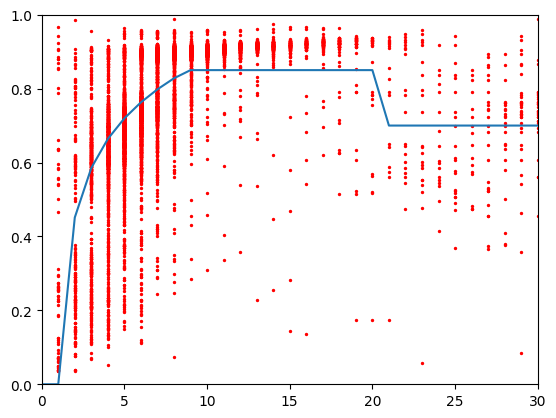

In [ ]:
def f(a,x):
  if (x-opt)*a[1] <= 0:
    res = 0
  elif x > size:
    res = 0.7
  else:
    res = min(max_discount,max(0,a[0]*np.log((x-opt)*a[1])))
  return res
curve_adjusted = [f(a_star,x) for x in range(50)]
plt.plot(curve_adjusted)
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,30) # x axis size

Now we'll group discounts by debt, ordered by newest to oldest

In [ ]:
n_act = 4 #number of activities to analize for each debt

In [ ]:
base['ranking'] = base.groupby(by='debt_id')['executed_date'].rank(ascending=False) # rank function enumerate conditional subsets
debts = base[['debt_id']].drop_duplicates() # the duble brackets [[]] let us keep the column as dataframe
for i in reversed(range(1,n_act + 1)): #range goes from 0 to n-1, thats why we need to specify begginning and end + 1
  ranking = base[base.ranking == i][['debt_id','deliq_act','real_discount']]
  ranking[i] = list(zip(ranking.deliq_act,ranking.real_discount))
  debts = pd.merge(debts,ranking[['debt_id',i]],on='debt_id',how='left').fillna('no_act')

In [ ]:
debts

,debt_id,4,3,2,1
0,57764,"(96, 0.7651706066068791)","(97, 0.7651706066068791)","(98, 0.7651706066068791)","(99, 0.7651706066068791)"
1,74883,no_act,no_act,"(94, 0.7597603145558466)","(95, 0.954649239707512)"
2,74918,"(91, 0.8288361258393094)","(92, 0.8288361258393094)","(93, 0.8288361258393094)","(94, 0.8288361258393094)"
3,241614,"(108, 0.6263750252789306)","(109, 0.6263750252789306)","(110, 0.6263750252789306)","(111, 0.6263750252789306)"
4,65066,no_act,no_act,no_act,"(124, 0.9058430285589864)"
...,...,...,...,...,...
4431,1429106,no_act,no_act,no_act,"(1, 0.2313157769417592)"
4432,1430073,no_act,no_act,no_act,"(5, 0.7852762801573858)"
4433,1430238,no_act,no_act,no_act,"(3, 0.3033819318491865)"
4434,1430448,no_act,no_act,no_act,"(2, 0.3239934306085547)"


In [ ]:
debts_categorized = debts[debts[4] != 'no_act'].copy()
for row in range(len(debts)):
  for i in range(1,n_act+1):
    pair = debts.loc[row,i]
    if pair == 'no_act':
      res = 'no_act'
    elif pair[0] > size:
      if pair[1] >= max_discount:
        res = 'better'
      else:
        res = 'worse'
    elif pair[1] >= curve_adjusted[pair[0]]:
      res = 'better'
    else:
      res = 'worse'
    debts_categorized.loc[row,i] = res

In [ ]:
debts_categorized['category'] = 0
for ind in debts_categorized.index:
  row = debts_categorized.loc[ind,:]
  if len(row[row == 'better']) > 1:
    debts_categorized.loc[ind,'category'] = 'better'
  else:
    debts_categorized.loc[ind,'category'] = 'worse'

In [ ]:
debts = pd.merge(debts,debts_categorized[['debt_id','category']],on='debt_id',how='left')

In [ ]:
debts# .drop(columns=['category_x','category_y'],inplace=True)

,debt_id,4,3,2,1,category
0,57764,"(96, 0.7651706066068791)","(97, 0.7651706066068791)","(98, 0.7651706066068791)","(99, 0.7651706066068791)",worse
1,74883,no_act,no_act,"(94, 0.7597603145558466)","(95, 0.954649239707512)",NaN
2,74918,"(91, 0.8288361258393094)","(92, 0.8288361258393094)","(93, 0.8288361258393094)","(94, 0.8288361258393094)",worse
3,241614,"(108, 0.6263750252789306)","(109, 0.6263750252789306)","(110, 0.6263750252789306)","(111, 0.6263750252789306)",worse
4,65066,no_act,no_act,no_act,"(124, 0.9058430285589864)",NaN
...,...,...,...,...,...,...
4431,1429106,no_act,no_act,no_act,"(1, 0.2313157769417592)",NaN
4432,1430073,no_act,no_act,no_act,"(5, 0.7852762801573858)",NaN
4433,1430238,no_act,no_act,no_act,"(3, 0.3033819318491865)",NaN
4434,1430448,no_act,no_act,no_act,"(2, 0.3239934306085547)",NaN


In [ ]:
l = []
m = []
for row in debts[debts.category == 'better'].index:
  for i in range(1,n_act+1):
    l.append(debts[debts.category == 'better'].loc[row,i])
for row in debts[debts.category == 'worse'].index:
  for i in range(1,n_act+1):
    m.append(debts[debts.category == 'worse'].loc[row,i])

In [ ]:
ll=pd.DataFrame(columns=['month','discount'])
i = 0
for tup in l:
  ll.loc[i,:] = tup
  i = i + 1
mm = pd.DataFrame(columns=['month','discount'])
i = 0
for tup in m:
  mm.loc[i,:] = tup
  i = i + 1

(0.0, 50.0)

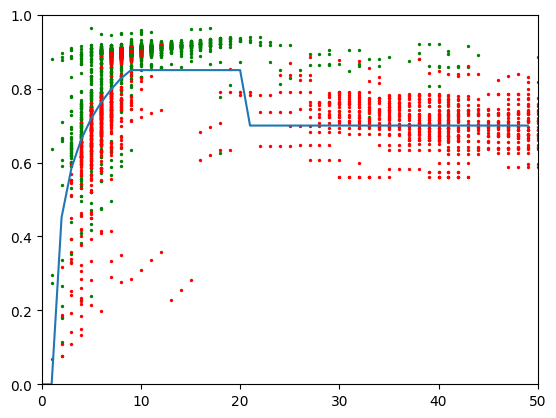

In [ ]:
plt.scatter(ll['month'],ll['discount'], s = 2, color = 'green' )
plt.scatter(mm['month'],mm['discount'], s = 2, color = 'red' )
plt.plot(curve_adjusted)
plt.ylim(0,1)
plt.xlim(0,50)